In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
housing = pd.read_csv('housing_prices_numeric.csv')

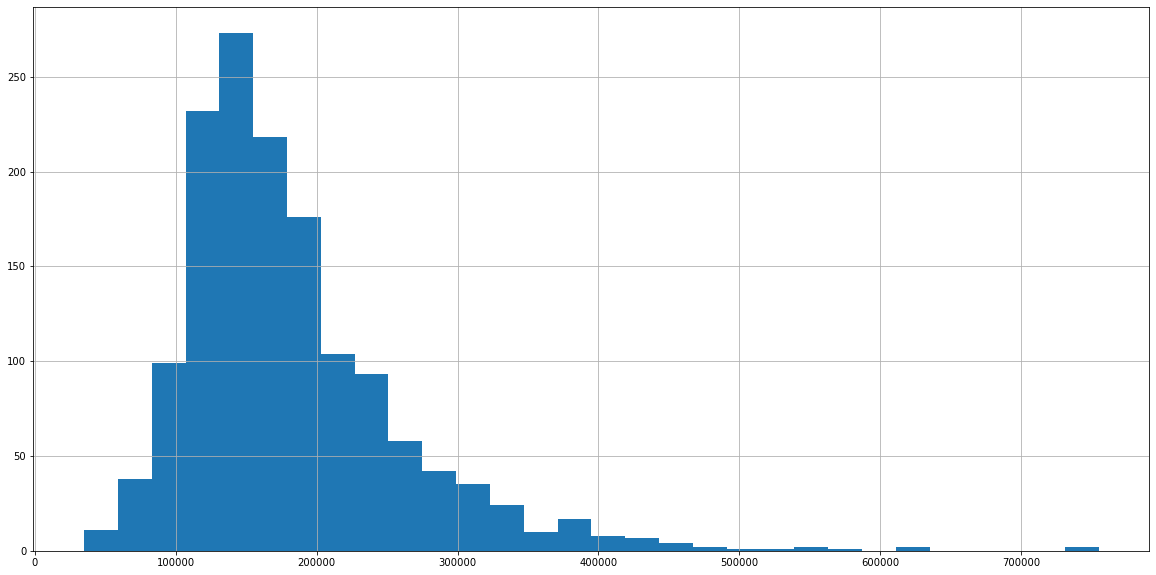

In [3]:
# distribution of house prices
housing.SalePrice.hist(bins=30, figsize=(20,10));

In [4]:
housing.drop_duplicates(inplace=True)
housing.drop(['SaleType', 'SaleCondition', 'MoSold', 'YrSold'], axis=1, inplace=True)
housing = housing[housing['MasVnrArea'].notna()].copy()
ordinal_columns = ["LotShape", "Utilities", "LandSlope", "ExterQual", "ExterCond", 
            "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", 
            "HeatingQC", "Electrical", "KitchenQual", "Functional", "FireplaceQu",
            "GarageFinish", "GarageQual", "GarageCond", "Fence", "PoolQC"]
LotShape_cats = ["Reg", "IR1", "IR2", "IR3"]
Utilities_cats = ["AllPub", "NoSewr", "NoSeWa", "ELO"]
LandSlope_cats = ["Gtl", "Mod", "Sev"]
ExterQual_cats = ["Po", "Fa", "TA", "Gd", "Ex"]
ExterCond_cats = ["Po", "Fa", "TA", "Gd", "Ex"]
BsmtQual_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
BsmtCond_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
BsmtExposure_cats = ["N_A", "No", "Mn", "Av", "Gd"]
BsmtFinType1_cats = ["N_A", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
BsmtFinType2_cats = ["N_A", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
HeatingQC_cats = ["Po", "Fa", "TA", "Gd", "Ex"]
Electrical_cats = ["N_A", "Mix", "FuseP", "FuseF", "FuseA", "SBrkr"]
KitchenQual_cats = ["Po", "Fa", "TA", "Gd", "Ex"]
Functional_cats = ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"]
FireplaceQu_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
GarageFinish_cats = ["N_A", "Unf", "RFn", "Fin"]
GarageQual_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
GarageCond_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
Fence_cats = ["N_A", "MnWw", "GdWo", "MnPrv", "GdPrv"]
PoolQC_cats = ["N_A", "Fa", "TA", "Gd", "Ex"]
cats_ord = [LotShape_cats, Utilities_cats, LandSlope_cats, ExterQual_cats,
            ExterCond_cats, BsmtQual_cats, BsmtCond_cats, BsmtExposure_cats,
            BsmtFinType1_cats, BsmtFinType2_cats, HeatingQC_cats, Electrical_cats,
            KitchenQual_cats, Functional_cats, FireplaceQu_cats, GarageFinish_cats,
            GarageQual_cats, GarageCond_cats, Fence_cats, PoolQC_cats]

# [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/clustering.html)

[StatQuest PCA brief 5 minute overview](https://www.youtube.com/watch?v=HMOI_lkzW08)

[StatQuest PCA 20 minute step by step walkthrough](https://www.youtube.com/watch?v=FgakZw6K1QQ)

In [5]:
from sklearn.decomposition import PCA

pca = PCA()

In [6]:
X = housing.drop(columns="SalePrice")
y = housing["SalePrice"]

def impute_categ_nulls(df):
    df = df.fillna("N_A")
    return df

cat_imputer = FunctionTransformer(impute_categ_nulls, validate=False)

numeric_features = list(X.select_dtypes(exclude=["object"]))

numeric_pipe = make_pipeline(
    SimpleImputer(strategy="median")
)

categorical_features_ordinal = ordinal_columns
categorical_transformer_ordinal = OrdinalEncoder(categories=cats_ord)
categorical_features_onehot = list(set(list(X.select_dtypes(include=["object"]))) - set(ordinal_columns))
categorical_transformer_onehot = OneHotEncoder(handle_unknown="ignore")

categorical_preprocessor = ColumnTransformer(
    transformers=[
        ("cat_ordinal", categorical_transformer_ordinal, categorical_features_ordinal),
        ("cat_onehot", categorical_transformer_onehot, categorical_features_onehot),
    ]
)

categorical_pipe = make_pipeline(
    cat_imputer,
    categorical_preprocessor
)


cat_num_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_features),
        ("cat_pipe", categorical_pipe, list(X.select_dtypes(include=["object"]))),
    ]
)

final_pipe = make_pipeline(
    cat_num_preprocessor,
    VarianceThreshold(),
    StandardScaler(),
    pca,
    RandomForestRegressor()
)

pipe_params = {
    'pca__n_components': [5, 15, 30, 60],
    'randomforestregressor__max_depth': [10, 20, 40],
    'randomforestregressor__min_samples_split': [2, 3, 5],
    'randomforestregressor__min_samples_leaf': [1, 2, 5]
}

clf = GridSearchCV(final_pipe, pipe_params, cv = 10, scoring='neg_root_mean_squared_error', 
                   error_score='raise')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)

clf.best_params_

{'pca__n_components': 15,
 'randomforestregressor__max_depth': 20,
 'randomforestregressor__min_samples_leaf': 2,
 'randomforestregressor__min_samples_split': 3}

In [7]:
y_pred = clf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mae

17407.406222263126

In [8]:
mean_price = round(housing.SalePrice.mean())

relative_error = mae / mean_price
relative_error

0.09637851907240885

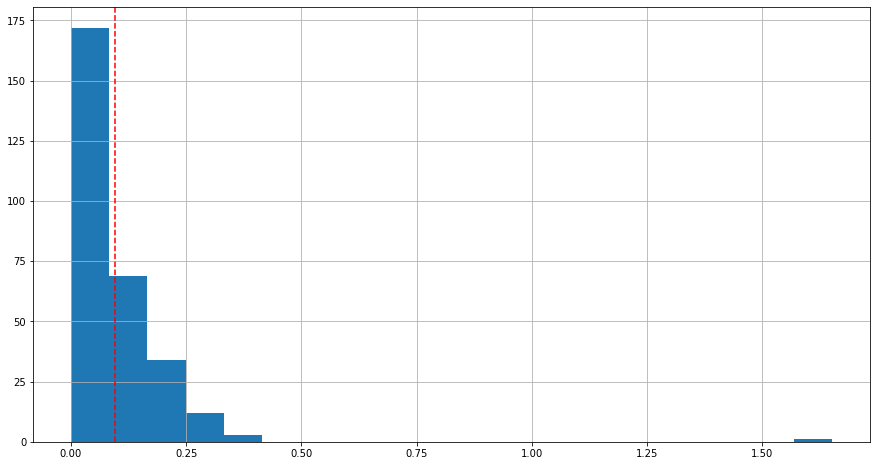

In [9]:
X_test_results = X_test.copy()

X_test_results["true_price"] = y_test
X_test_results["predicted_price"] = y_pred
X_test_results["absolute_error"] = abs(X_test_results["true_price"] - X_test_results["predicted_price"])
X_test_results["relative_error"] = X_test_results["absolute_error"] / X_test_results["true_price"]

ax = X_test_results.relative_error.hist(bins=20, figsize=(15,8))
ax.axvline(relative_error, color="red", linestyle="--");